RedNeuronal(
  (aplanar): Flatten(start_dim=1, end_dim=-1)
  (red): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
)
<class 'torch.Tensor'>
<class 'int'>
<class 'torch.Tensor'>
tensor([[ 0.2277, -0.1734,  0.2285, -0.0989, -0.1202, -0.0772, -0.1272,  0.0197,
          0.1425,  0.2017]], grad_fn=<AddmmBackward0>)
Predicción: 2, Real: 8
-------------------------------------
tensor(2.1944, grad_fn=<NllLossBackward0>)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.2
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


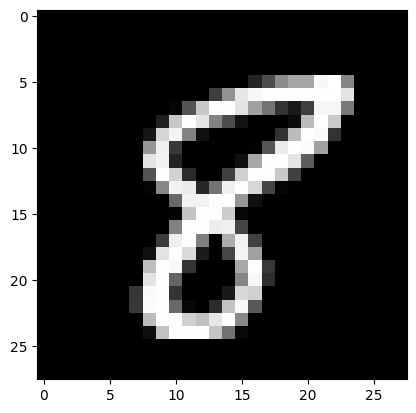

In [24]:
import torch
from torch import nn
from torchvision import datasets # Para descargar el dataset
from torchvision.transforms import ToTensor # Para convertir los datos a Tensores
import matplotlib.pyplot as plt # Para graficar las imágenes + categorías
from torch.utils.data import DataLoader # Para cargar los datos en lotes

# Definir el dispositivo
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

# Crear el directorio "datos" y ejecutar el siguiente código:
data_mnist = datasets.MNIST(
    root = "datos", # Carpeta donde se almacenará
    train=True, # True: 60.000 imágenes, False: 10.000 imágenes
    download=True,
    transform=ToTensor() # Convertir imágenes a tensores
)

torch.manual_seed(123)
train, val, test = torch.utils.data.random_split(
data_mnist, [0.8, 0.1, 0.1] #80% entrenamiento 10 validacion 10 prueba
)

class RedNeuronal(nn.Module):
  # imagen 28x28px escala grises - flatten 784 -> capa entrada 15 neuronas ->
  # activación ReLU -> salida 10 neuronas -> activación softmax
  def __init__(self):
    super().__init__()
    #capas:
    self.aplanar = nn.Flatten()
    self.red = nn.Sequential( #conectar las capas de forma secuencial
        #tamaño de imagen 28*28 flatten + (15 neuronas capa oculta)
        nn.Linear(28*28, 15),
        nn.ReLU(), #activar ReLU
        # capa salida: conecta las 15 neuronas anteriores con las 10 de salida
        nn.Linear(15,10)
    )
#PROPAGACION HACIA ADELANTE
  def forward(self, data): #procesar dato de entrada (784)
    data = self.aplanar(data)
    DataOutputs = self.red(data)
    return DataOutputs

modelo = RedNeuronal().to(device)
print(modelo)
torch.manual_seed(123)
train, val, test = torch.utils.data.random_split(
data_mnist, [0.8, 0.1, 0.1]
)

img, lbl = train[100]
print(type(img))
print(type(lbl))
#el tipo de dato de label es int y tiene que ser tensor por lo tanto:
lbl = torch.tensor(lbl).reshape(1)
print(type(lbl))

DataOutputs = modelo(img.to(device))
print(DataOutputs)

#numero mas alto en el vector de predicciones
posMax = DataOutputs.argmax(1)
#graficar imagen
plt.imshow(img.cpu().squeeze(), cmap="gray");
print(f"Predicción: {posMax.item()}, Real: {lbl.item()}")

#propagacion hacia atras
fn_perdida = nn.CrossEntropyLoss()
#SDG gradiente descendente
#lr learning rate
print("-------------------------------------")
optimizador = torch.optim.SGD(modelo.parameters(), lr=0.2)
losts = fn_perdida(DataOutputs, lbl)
print(losts)
#calcular las variaciones de la perdida
losts.backward()
#actualizar los parametros
optimizador.step()
#borrar gradientes calculados anteriormente
optimizador.zero_grad()
print(optimizador)

#presentar lotes pequeños hasta completar el 80%
TAM_LOTE = 1000 #Batch size

train_loader = DataLoader(
    dataset = train,
    batch_size = TAM_LOTE,
    shuffle= True #Mezcla de datos aleatoreamente
)

val_loader = DataLoader(
    dataset = val,
    batch_size = TAM_LOTE,
    shuffle = False
)
#ENTRENAMIENTO
#tasa de aprendizaje 10%
TASA_APRENDIZAJE = 0.1 #LEARNING RATE
EPOCH = 10 #ITERACIONES ENTRENAMIENTO PARA EJECUTAR FP Y BP

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Cantidad de datos de entrenamiento y cantidad de lotes
    train_size = len(dataloader.dataset)
    nlotes = len(dataloader)

    # Indicarle a Pytorch que entrenaremos el modelo
    model.train()

    # Inicializar acumuladores pérdida y exactitud
    perdida_train, exactitud = 0, 0

    # Presentar los datos al modelo por lotes (de tamaño TAM_LOTE)
    for nlote, (X, y) in enumerate(dataloader):
        # Mover "X" y "y" a la GPU
        X, y = X.to(device), y.to(device)

        # Forward propagation
        DataOutputs = model(X)

        # Backpropagation
        losts = fn_perdida(DataOutputs, y)
        losts.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Acumular valores de pérdida y exactitud
        # perdida_train <- perdida_train + perdida_actual
        # exactitud <- exactitud + numero_aciertos_actuales
        perdida_train += losts.item()
        exactitud += (DataOutputs.argmax(1)==y).type(torch.float).sum().item()

        # Imprimir en pantalla la evolución del entrenamiento (cada 10 lotes)
        if nlote % 10 == 0:
            # Obtener el valor de la pérdida (losts) y el número de datos procesados (ndatos)
            ndatos = nlote*TAM_LOTE

            # E imprimir en pantalla
            print(f"\tPérdida: {losts.item():>7f}  [{ndatos:>5d}/{train_size:>5d}]")

    # Al terminar de presentar todos los datos al modelo, promediar pérdida y exactitud
    perdida_train /= nlotes # Pérdida promedio = pérdida acumulada / número de lotes
    exactitud /= train_size # Exactitud promedio = exactitud acumulada / número de datos

    # E imprimir información
    print(f'\tExactitud/pérdida promedio:')
    print(f'\t\tEntrenamiento: {(100*exactitud):>0.1f}% / {perdida_train:>8f}')

In [22]:
def val_loop(dataloader, model, loss_fn):
    # Cantidad de datos de validación y cantidad de lotes
    val_size = len(dataloader.dataset)
    nlotes = len(dataloader)

    # Indicarle a Pytorch que validaremos el modelo
    model.eval()

    # Inicializar acumuladores pérdida y exactitud
    perdida_val, exactitud = 0, 0

    # Evaluar (generar predicciones) usando "no_grad"
    #para indicar que no se va hacer entrenamiento
    with torch.no_grad():
        for X, y in dataloader:
            # Mover "X" y "y" a la GPU
            X, y = X.to(device), y.to(device)

            # Propagación hacia adelante (predicciones)
            DataOutputs = model(X)

            # Acumular valores de pérdida y exactitud
            perdida_val += loss_fn(DataOutputs, y).item()
            exactitud += (DataOutputs.argmax(1) == y).type(torch.float).sum().item()

    # Tras generar las predicciones calcular promedios de pérdida y exactitud
    perdida_val /= nlotes
    exactitud /= val_size

    # E imprimir en pantalla
    print(f"\t\tValidación: {(100*exactitud):>0.1f}% / {perdida_val:>8f} \n")

LLAMADO DE LAS FUNCIONES DE ENTRENAMIENTO Y VALIDACION:

In [28]:
for t in range(EPOCH):
    print(f"Iteración {t+1}/{EPOCH}\n-------------------------------")
    # Entrenar
    train_loop(train_loader, modelo, fn_perdida, optimizador)
    # Validar
    val_loop(val_loader, modelo, fn_perdida)
print("Listo, el modelo ha sido entrenado!")

Iteración 1/10
-------------------------------
	Pérdida: 2.442133  [    0/48000]
	Pérdida: 1.996563  [10000/48000]
	Pérdida: 1.579325  [20000/48000]
	Pérdida: 1.112962  [30000/48000]
	Pérdida: 0.836789  [40000/48000]
	Exactitud/pérdida promedio:
		Entrenamiento: 59.8% / 1.454363
		Validación: 80.9% / 0.741644 

Iteración 2/10
-------------------------------
	Pérdida: 0.709132  [    0/48000]
	Pérdida: 0.612333  [10000/48000]
	Pérdida: 0.568551  [20000/48000]
	Pérdida: 0.522072  [30000/48000]
	Pérdida: 0.507162  [40000/48000]
	Exactitud/pérdida promedio:
		Entrenamiento: 85.2% / 0.564748
		Validación: 86.4% / 0.488694 

Iteración 3/10
-------------------------------
	Pérdida: 0.454284  [    0/48000]
	Pérdida: 0.446514  [10000/48000]
	Pérdida: 0.410799  [20000/48000]
	Pérdida: 0.399092  [30000/48000]
	Pérdida: 0.396990  [40000/48000]
	Exactitud/pérdida promedio:
		Entrenamiento: 88.3% / 0.425565
		Validación: 88.5% / 0.411554 

Iteración 4/10
-------------------------------
	Pérdida: 0.40

In [38]:
def predecir(modelo, img):
  DataOutputs = modelo(img)
  prediccion = DataOutputs.argmax(1).item()

  plt.imshow(img.cpu().squeeze(), cmap= "gray")
  plt.title(f'categoria que predijo la ia: {prediccion}')

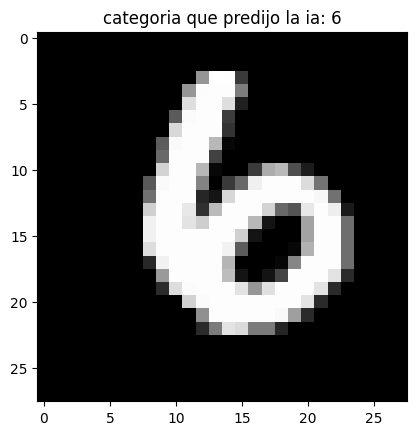

In [60]:
img, label = test[50] #6k de imagenes para probar

predecir(modelo, img)